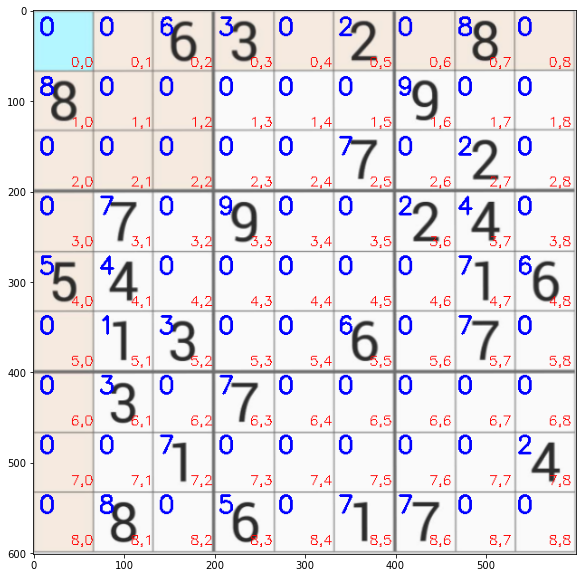

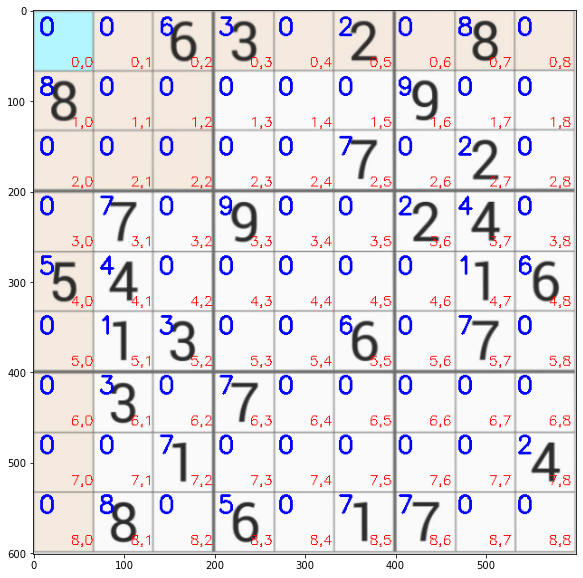

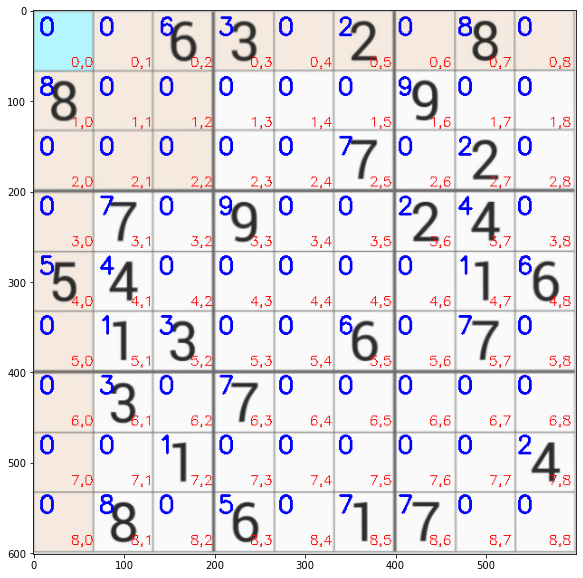

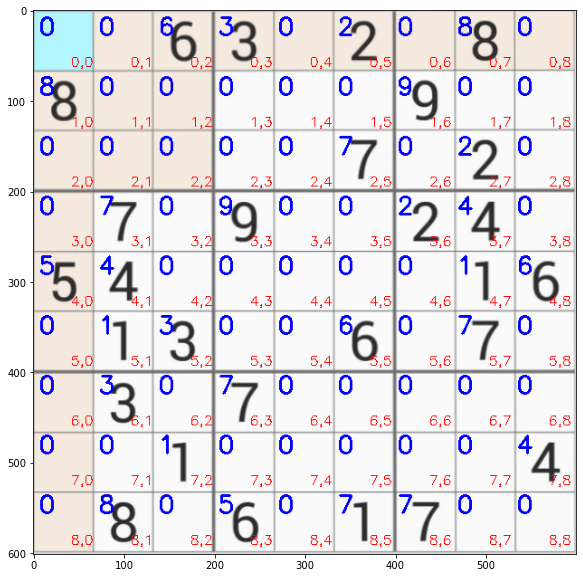

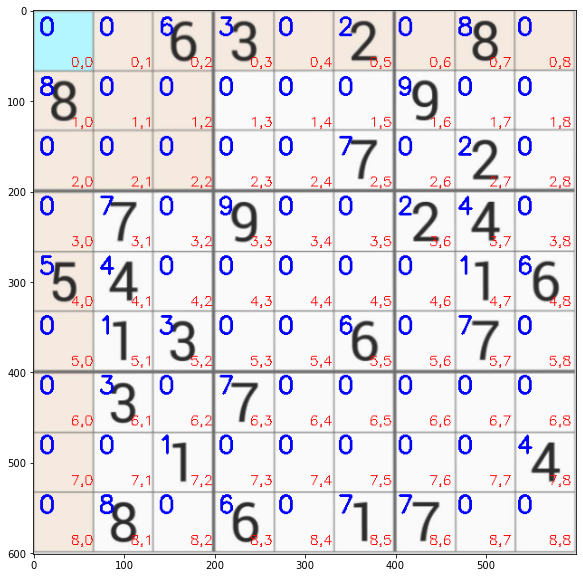

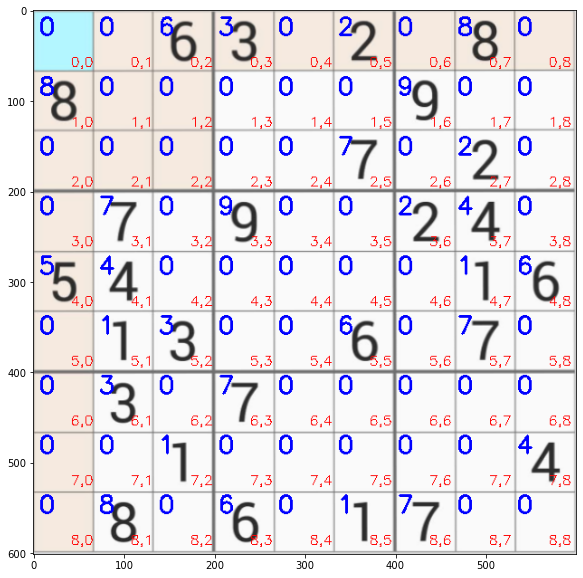

The puzzle has been SOLVED!


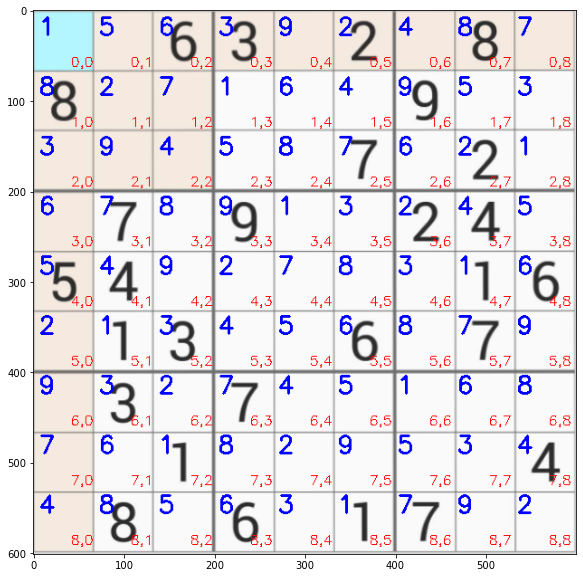

In [1]:
# Import Dependencies

import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from Sudoku import solveSudoku

# Load model and image
# Select between images 1-6
sudoku_model = load_model('model/model_mnist/')
image_path = 'sudoku images/6.png'
image_shape = [28,28]

# Reading Sudoku puzzle image

def find_puzzle(img):
    real = img.copy()
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur to reduce noise
    blur = cv2.GaussianBlur(gray,(7,7),1)
    # Apply adapative threshholding
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    thresh = cv2.bitwise_not(thresh)
    # Find contours of puzzle
    contour = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    contour = sorted(contour,key=cv2.contourArea,reverse=True)

    puzzle_contour = None

    # Loop over contours
    for c in contour:
        # Approximate the contour
        peri = cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,0.02*peri,True)
        # If contour has 4 vertices then we have found the puzzle
        if len(approx)==4:
            puzzle_contour=approx
            break
    # If not then print following text
    if puzzle_contour is None:
        raise Exception(("Unable to find Sudoku puzzle outline. Debug thresholding and contour steps."))     

    # Draw contour (perimeter) around puzzle
    cv2.drawContours(real, [puzzle_contour], -1, (0, 255, 0), 2)
    # Apply four point transform to get a straight view of the puzzle and return it
    puzzle = four_point_transform(img, puzzle_contour.reshape(4, 2))
    warped = four_point_transform(gray, puzzle_contour.reshape(4, 2))

    return puzzle,warped

# Extracting digits in Sudoku puzzle image

# Threshhold warped image
def extract_digit(cell):
    thresh = cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    # Clear any white pixels around border
    thresh = clear_border(thresh)
    # Find contours in threshholded image
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)

    # If no contours are found then return back as empty cell
    if len(contour) == 0:return None

    # Find largest contour in the cell and create mask for the contour
    c = max(contour, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = thresh.shape
    percentfilled = cv2.countNonZero(mask) / float(w * h)

    # If less than 3% of the mask is filled then recognise as noise can and ignore contour
    if percentfilled < 0.03:return None

    # Apply mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    kernel = np.ones((1,1),np.uint8)
    digit = cv2.dilate(digit,kernel,iterations=1)

    # Return the digit to the calling function
    return digit

# Display recognised numbers on puzzle

def display_numbers_on_board(board,puzzle):
    x = puzzle.copy()
    k = 0
    for i in range(9):
        for j in range(9):
            startX,startY,endX,endY = cell_locs[k]
            testX = int((endX - startX) * 0.1)
            testY = int((endY - startY) * -0.6)
            testX += startX
            testY += endY
            cv2.putText(x,str(board[i][j]),(testX,testY),cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,0,255),2)
            cv2.putText(x,(str(i)+','+str(j)),(testX+35,testY+35),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
            
            k+=1
    
    # Displaying sudoku puzzle
    plt.figure(figsize=(14,10))
    plt.imshow(x)
    plt.show()
    return x

# Resize image
img = cv2.imread(image_path)
img = imutils.resize(img,width=600)

# Extract puzzle and resize
puzzle,warped = find_puzzle(img)
puzzle = imutils.resize(puzzle,width=600)
warped = imutils.resize(warped,width=600)

# Determine step size for x and y directions (cell size)
step_x = warped.shape[1]//9
step_y = warped.shape[0]//9

# Create board and initialise values as 0
board = np.zeros(shape=(9,9),dtype='int')
# Create array which contains cell locations and coordinates
cell_locs = []

# Loop through each cell of the 9x9 puzzle
# On each cell read and predict the number and place into the board array
# Store cell locations in cell_locs
for i in range(9):
    for j in range(9):
        topleftx = j*step_x
        toplefty = i*step_y
        rightendx= (j+1)*step_x
        rightendy = (i+1)*step_y
        cell = warped[toplefty:rightendy, topleftx:rightendx]
        digit = extract_digit(cell)
        if digit is not None:
            roi = cv2.resize(digit,tuple(image_shape))
            roi = roi.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)
            pred = sudoku_model.predict(roi).argmax(axis=1)[0]
            board[i,j] = pred
        cell_locs.append([topleftx,toplefty,rightendx,rightendy])

        
x = display_numbers_on_board(board,puzzle)

# Prompt to enable user entry to amend any incorrect 

while 1:
    # User able to confirm if numbers were predicted correctly
    # If not they are able to amend wrong predictions
    res = input('Are all numbers predicted correctly in the Sudoku puzzle? (y/n)')
    if res=='n':
        cx,cy,ele = input('To amend wrong predictions; Input row number, column number, correct number for incorrect cell For eg. --> 1 2 1:  ').split()
        try:
            board[int(cx),int(cy)] = int(ele)
        except:
            print('Out of range')
        display_numbers_on_board(board,puzzle)
    elif res=='y':
        print('The puzzle has been SOLVED!')
        break
    else:
        print('Wrong choice! Please amend any incorrect predictions and try again.')


# Solving the puzzle using solveSudoku

solved = solveSudoku(board)
x = display_numbers_on_board(board,puzzle)

cv2.imshow('solved',x)
cv2.waitKey(0)
cv2.destroyAllWindows()